# Batch size, Optimizers, Loss

We will study the behaviour of batch size, optimizers, and loss on a linear regression, as it makes the parameters easy to visualize.

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Fake data & basic linear regression

We create some random points roughly aligned, so we can perform a linear regression.

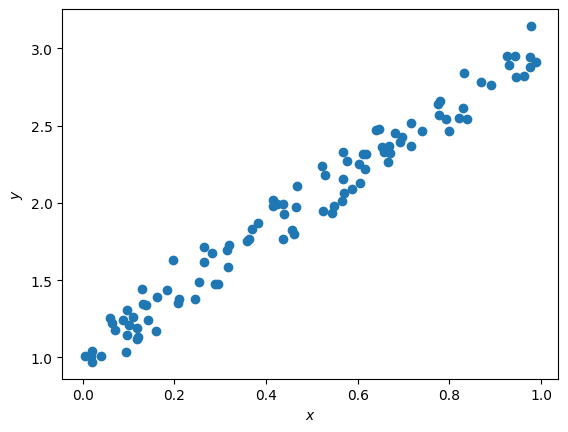

In [2]:
np.random.seed(0)

XS = np.random.rand(100, 1)
YS = 1 + 2 * XS + .1 * np.random.randn(100, 1)

plt.scatter(XS, YS)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

A linear regression is a simple model, where $y_{pred} = a*x+b$.
The loss (function we try to minimize) is usually the mean squared error $\mathcal{L}(a,b) = \sum_{i=1}^N ({y_{pred}}_i-y_i)^2 = \sum_{i=1}^N ((ax_i+b)-y_i)^2$.

Let's define a function that calculates the loss for $a \in \left[0,2\right]$ and $b \in \left[-1,3\right]$ (with a grid of $100 \times 100$ points), and plot the loss on that range.

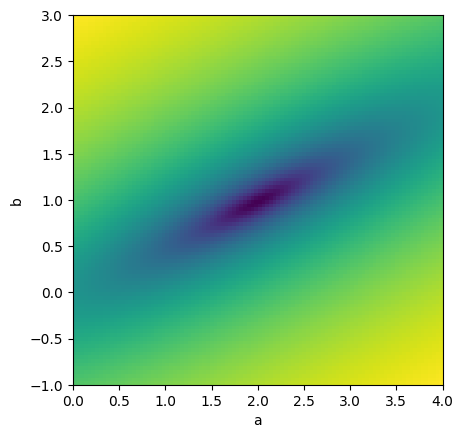

In [3]:
def loss_map(xs, ys, pow_err=2):
    aa = np.linspace(0,4, 100)
    bb = np.linspace(-1,3, 100)
    A, B = np.meshgrid(aa, bb)
    L = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            a = A[i,j]
            b = B[i,j]
            yhat = a*xs + b
            L[i,j] = np.log(np.mean(np.abs(ys-yhat)**pow_err))
    return L

L = loss_map(XS, YS)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.xlabel('a')
plt.ylabel('b')
plt.show()

We then create a tensor dataset from our points

In [4]:
XS_T = torch.from_numpy(XS).float()
YS_T = torch.from_numpy(YS).float()
dataset = TensorDataset(XS_T, YS_T)
dataset[0]

(tensor([0.5488]), tensor([1.9811]))

We create a `nn.Module` (a model) that is a linear function

In [5]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.a * x

Here is an example of training for our linear model.
On top of training, this cell also stores the evolution of values of $a$ and $b$ over time.

In [6]:
train_loader = DataLoader(dataset=dataset, batch_size=100)
torch.manual_seed(42)
model = LinearModel().to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.05)
a_s = [model.a.item()]
b_s = [model.b.item()]
t_s = [0]
t = time.time()
for epoch in range(1000):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch_hat = model(x_batch)
        loss = loss_fn(y_batch, y_batch_hat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        a_s.append(model.a.item())
        b_s.append(model.b.item())
        t_s.append(time.time() - t)

Here is a code to plot the evolution of $a$ and $b$ over time, and in the loss space:

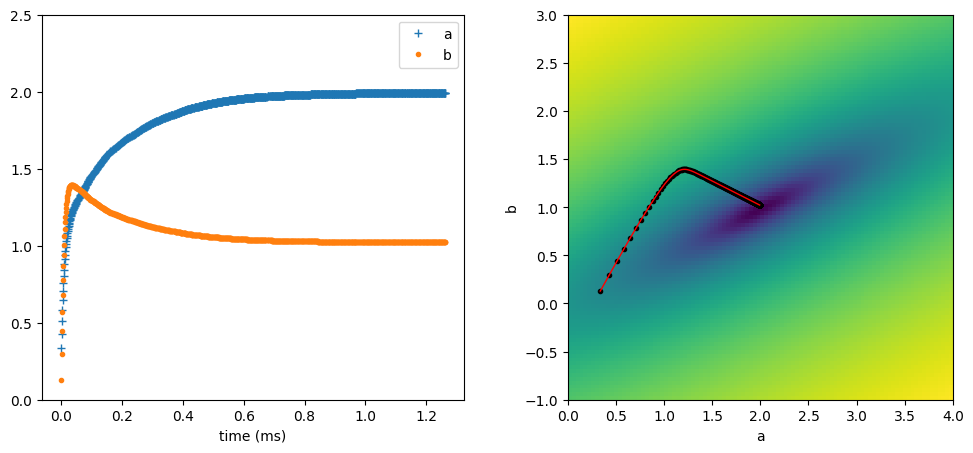

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(t_s, a_s, '+', label='a')
plt.plot(t_s, b_s, '.', label='b')
plt.legend()
plt.ylim(0, 2.5)
plt.xlabel("time (ms)")
plt.subplot(122)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.plot(a_s, b_s, "k.")
plt.plot(a_s, b_s, 'r', lw=1)
plt.xlim(0, 4)
plt.ylim(-1, 3)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

Combining the two cells above, create a function `plot_training` that create the two plots above.
The function should have arguments `n_epochs` (the number of epochs), `lr` (the learning rate), and `batch_size` (the size of the batches).
This function should also return the value of the parameters $a$ and $b$ at the end of the training.

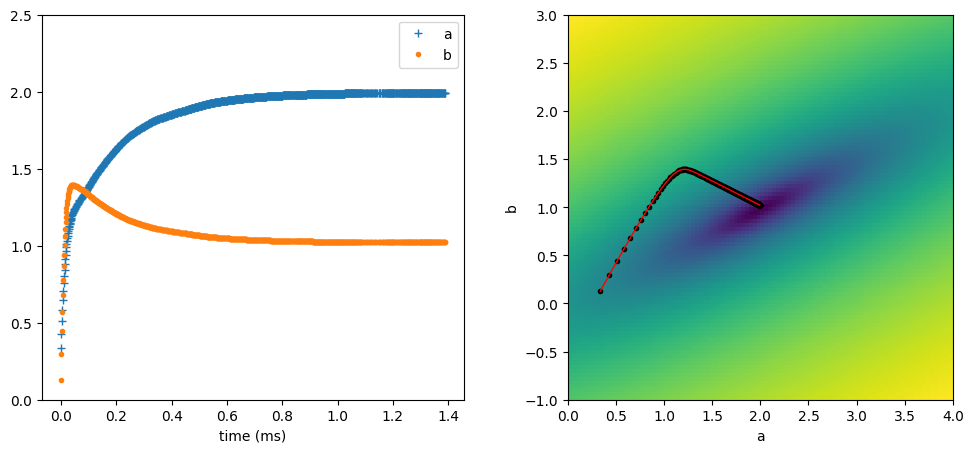

(1.992546796798706, 1.0227962732315063)

In [8]:
def plot_training(n_epochs, lr, batch_size):
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size)
    torch.manual_seed(42)
    model = LinearModel().to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=lr)
    a_s = [model.a.item()]
    b_s = [model.b.item()]
    t_s = [0]
    t = time.time()
    for epoch in range(n_epochs):
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch_hat = model(x_batch)
            loss = loss_fn(y_batch, y_batch_hat)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            a_s.append(model.a.item())
            b_s.append(model.b.item())
            t_s.append(time.time() - t)

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(t_s, a_s, '+', label='a')
    plt.plot(t_s, b_s, '.', label='b')
    plt.legend()
    plt.ylim(0, 2.5)
    plt.xlabel("time (ms)")
    plt.subplot(122)
    plt.imshow(L, extent=[0, 4, -1, 3])
    plt.plot(a_s, b_s, "k.")
    plt.plot(a_s, b_s, 'r', lw=1)
    plt.xlim(0, 4)
    plt.ylim(-1, 3)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.show()
    return model.a.item(), model.b.item()

plot_training(n_epochs=1000, lr=0.05, batch_size=100)

---

## Batch size

Try `n_epochs=10`, `lr=0.1`, `batch_size=100` this will be our basis, to be improved.

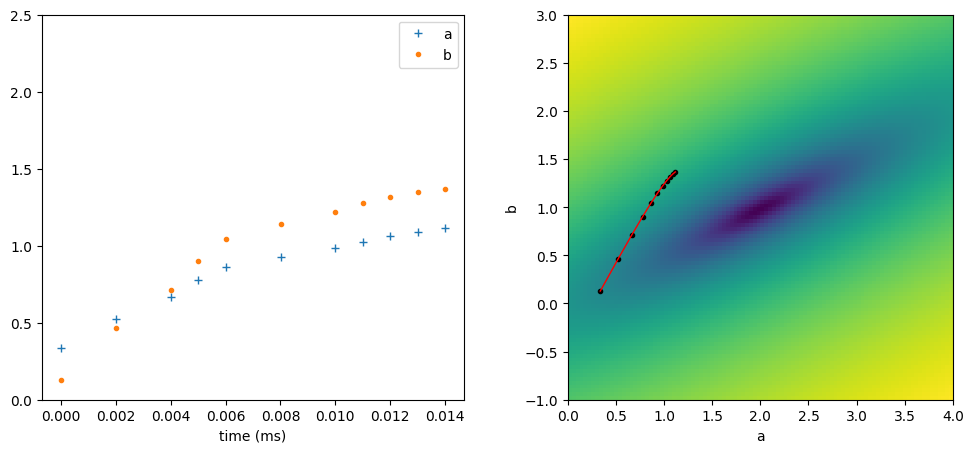

(1.1160752773284912, 1.366629719734192)

In [9]:
plot_training(n_epochs=10, lr=0.1, batch_size=100)

Increase the number of epoch untill convegrence is reached.

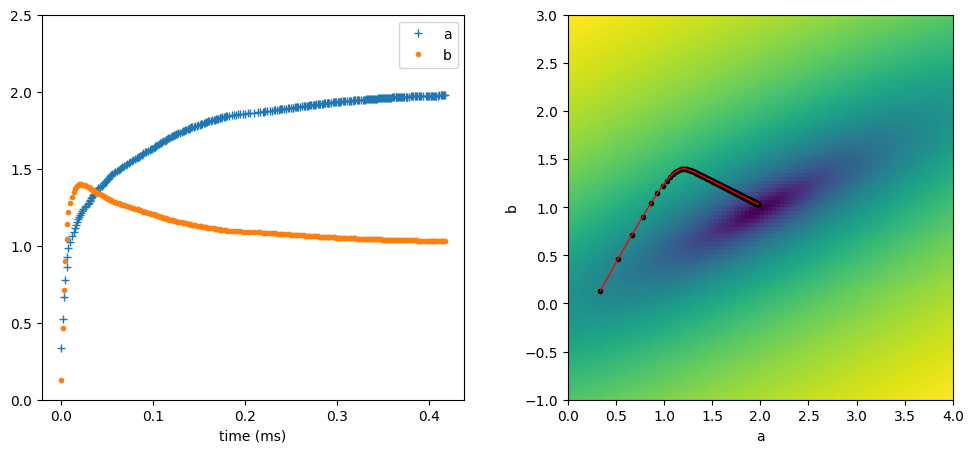

(1.977005958557129, 1.0306719541549683)

In [10]:
plot_training(n_epochs=300, lr=0.1, batch_size=100)

Let `lr=0.5`. How many epoch do you now need to reach convergence?

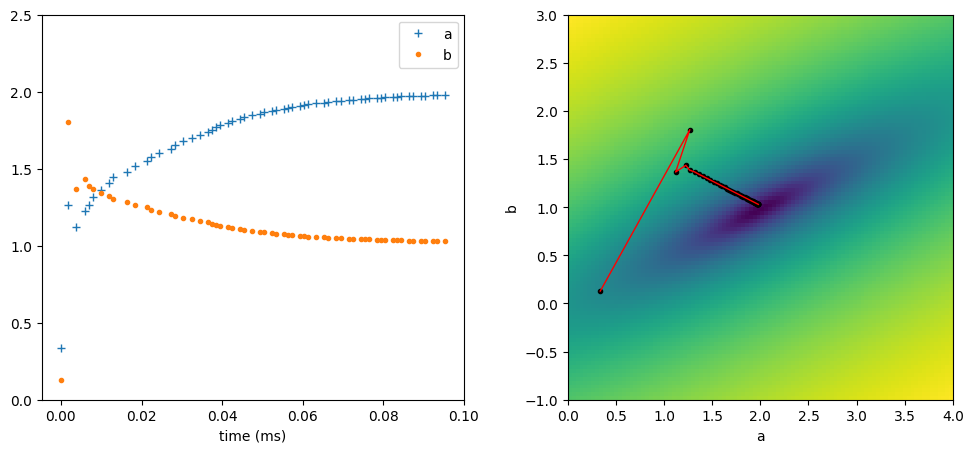

(1.9788039922714233, 1.029760718345642)

In [11]:
plot_training(n_epochs=60, lr=0.5, batch_size=100)